# **1. Import all Necessary Libraries**

In [51]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical



import tensorflow as tf
print(tf.__version__)

import warnings
warnings.filterwarnings("ignore")

2.16.1


In [52]:
print(os.listdir('/kaggle/input/digit-recognizer'))

['sample_submission.csv', 'train.csv', 'test.csv']


# **2. Data preparation**

## 2.1 Load data

In [53]:
# Load the data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
sub = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
print("Data's are Ready!!")

Data's are Ready!!


In [54]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
print(train.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


In [56]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [57]:
X = train.drop(labels = ['label'], axis = 1).values
y = train['label'].values

# let's free some space
#del train 

In [58]:
train.label.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

## 2.2 Check for null and missing values

In [59]:
# Missing values values
print('Number of null values in training set:',train.isnull().sum().sum())

Number of null values in training set: 0


In [60]:
# Check the data
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [61]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [63]:
print('Number of null values in test set:',test.isnull().sum().sum())

Number of null values in test set: 0


## 2.3 Normalization

In [64]:
X = X.astype('float32')

In [65]:
X = X / 255.0

## 2.4 Reshape

In [66]:
X = X.reshape(-1,28,28,1)

## 2.5 Label encoding

In [67]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y.astype(np.int32), num_classes = 10)

print(f"Label size {y.shape}")

Label size (42000, 10)


## 2.6 Split training and valdiation set

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [69]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (37800, 28, 28, 1)
X_test shape: (4200, 28, 28, 1)
y_train shape: (37800, 10)
y_test shape: (4200, 10)


## 2.7 Data Visualizations

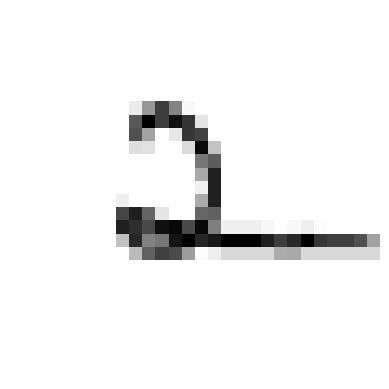

In [70]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[55]
plot_digit(some_digit)
 
plt.show()

Text(0.5, 1.0, 'Distribution of labels in training set')

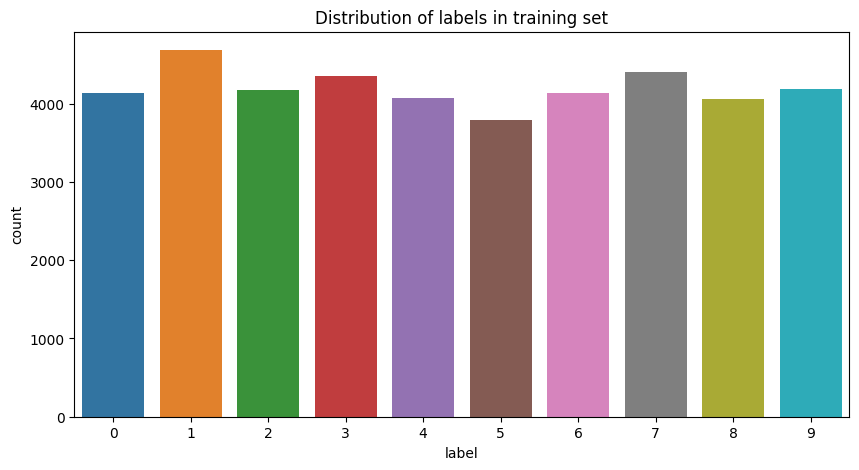

In [71]:
# Figure size
plt.figure(figsize=(10,5))

# Countplot
sns.countplot(x='label', data=train)
plt.title('Distribution of labels in training set')

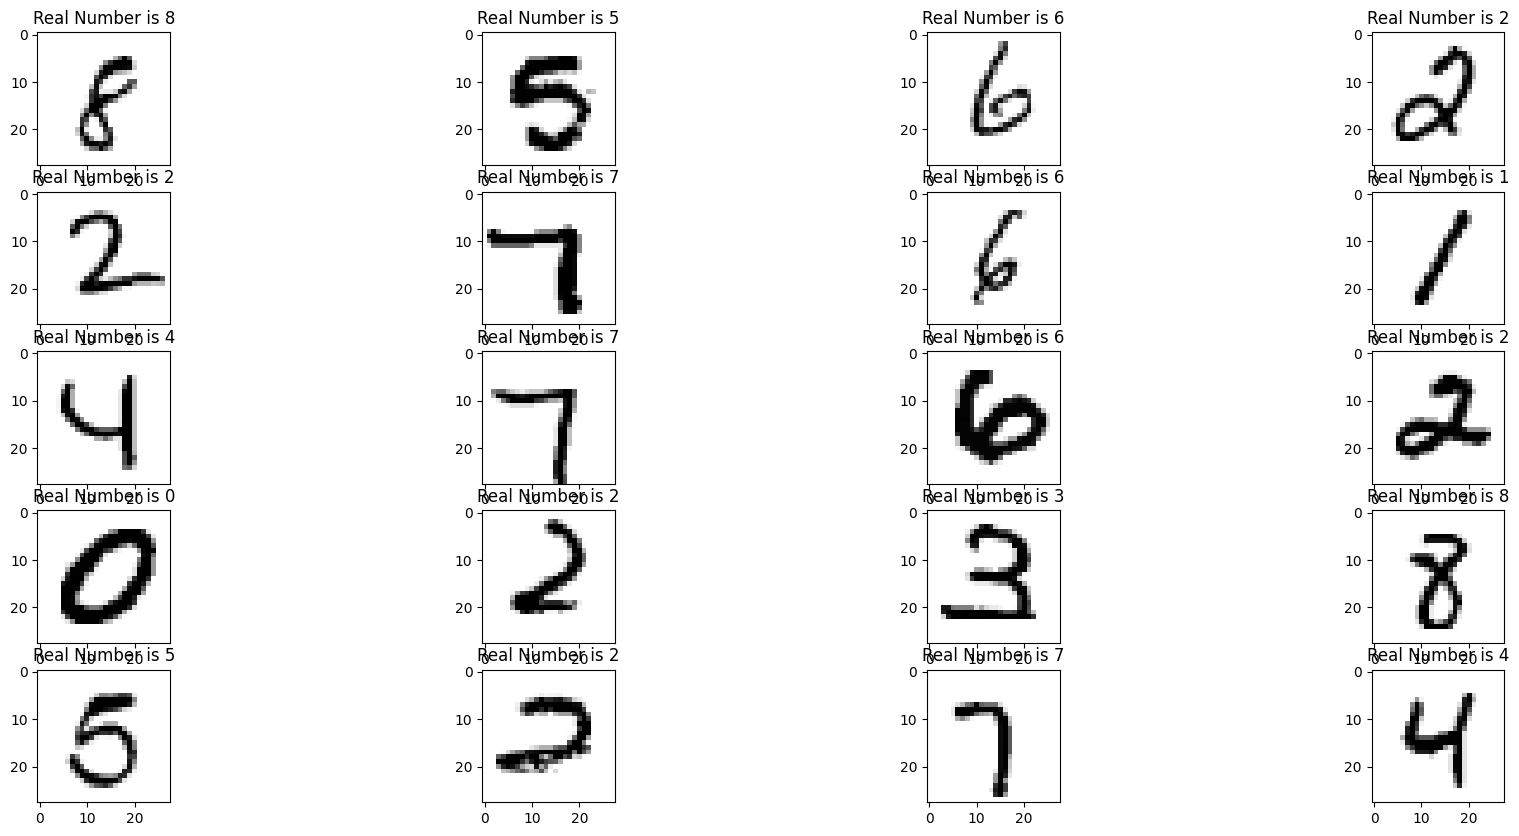

In [72]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(5, 4, figsize=(22, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i].reshape(28, 28), cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

## 2.8 Reshaping

In [73]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# **3. Model Development**

In [74]:
batch_size = 128
num_classes = 10
epochs = 100
input_shape = (28, 28, 1)

## 3.1 CNN

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))

model.add(Dense(10,activation="softmax"))

In [83]:
from tensorflow.keras.optimizers import SGD

# Define SGD optimizer with learning rate and momentum
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model with SGD optimizer
model.compile(loss="categorical_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Define RMSprop optimizer with a specific learning rate
rmsprop_optimizer = RMSprop(learning_rate=0.001, rho=0.9)

# Compile the model with RMSprop optimizer
model.compile(loss="categorical_crossentropy", optimizer=rmsprop_optimizer, metrics=["accuracy"])


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,714 (1.85 MB)

 Trainable params: 484,714 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Creating our MNIST network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compiling model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [99]:
# Creating a denser MNIST network
model = tf.keras.models.Sequential()

# Convolutional Layers with MaxPooling
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())

# Dense Layers (more units for a denser architecture)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

# Output layer for 10 classes
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,341,610 (5.12 MB)

 Trainable params: 1,337,066 (5.10 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [100]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        #zoom_range = 0.01, # Randomly zoom image 
        #width_shift_range=0.01,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.01,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip = False,
        #rescale = 1.0/255  # Normalize ediyoruz
) 


train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

In [101]:
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

In [102]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9  # Decrease learning rate by 10% after each 10 epochs.

lr_scheduler = LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", # metrics to monitor
    patience=10, # how many epochs to wait before stopping
    verbose=1,
    mode="max", # we need the maximum accuracy.
    restore_best_weights=True, # restore model weights from the epoch with the best value of the monitored metric
)

# Define learning rate reduction on plateau
rp = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=3,
    verbose=1,
    mode="max",
    min_lr=0.00001, # minimum learning rate
)

# Add checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras", # filepath to save the model
    monitor="val_accuracy", # metric to monitor
    verbose=1, 
    save_best_only=True, # save only the model with the best val_acc
    mode="max" # looking for the maximum value of val_acc
)

# Add callbacks to the training process
callbacks = [lr_scheduler, early_stopping, rp, checkpoint]

In [103]:
history = model.fit(
    train_gen, 
    epochs=epochs, 
    steps_per_epoch=train_steps,
    validation_data=test_gen,
    validation_steps=valid_steps, 
    callbacks=callbacks
)

Epoch 1/100
293/295 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8559 - loss: 0.5027
Epoch 1: val_accuracy improved from -inf to 0.95020, saving model to /kaggle/working/best_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8567 - loss: 0.5001 - val_accuracy: 0.9502 - val_loss: 0.1711 - learning_rate: 0.0010
Epoch 2/100
  1/295 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9688 - loss: 0.1646
Epoch 2: val_accuracy improved from 0.95020 to 0.97115, saving model to /kaggle/working/best_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.1646 - val_accuracy: 0.9712 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 3/100
290/295 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9733 - loss: 0.0910
Epoch 3: val_accuracy did not improve from 0.97115
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9733 - loss: 0.0910 - val_accuracy: 0.9568 - val_loss: 0.1548 - learning_rate: 0.0010
Epoch 4/100
  1/295 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - 

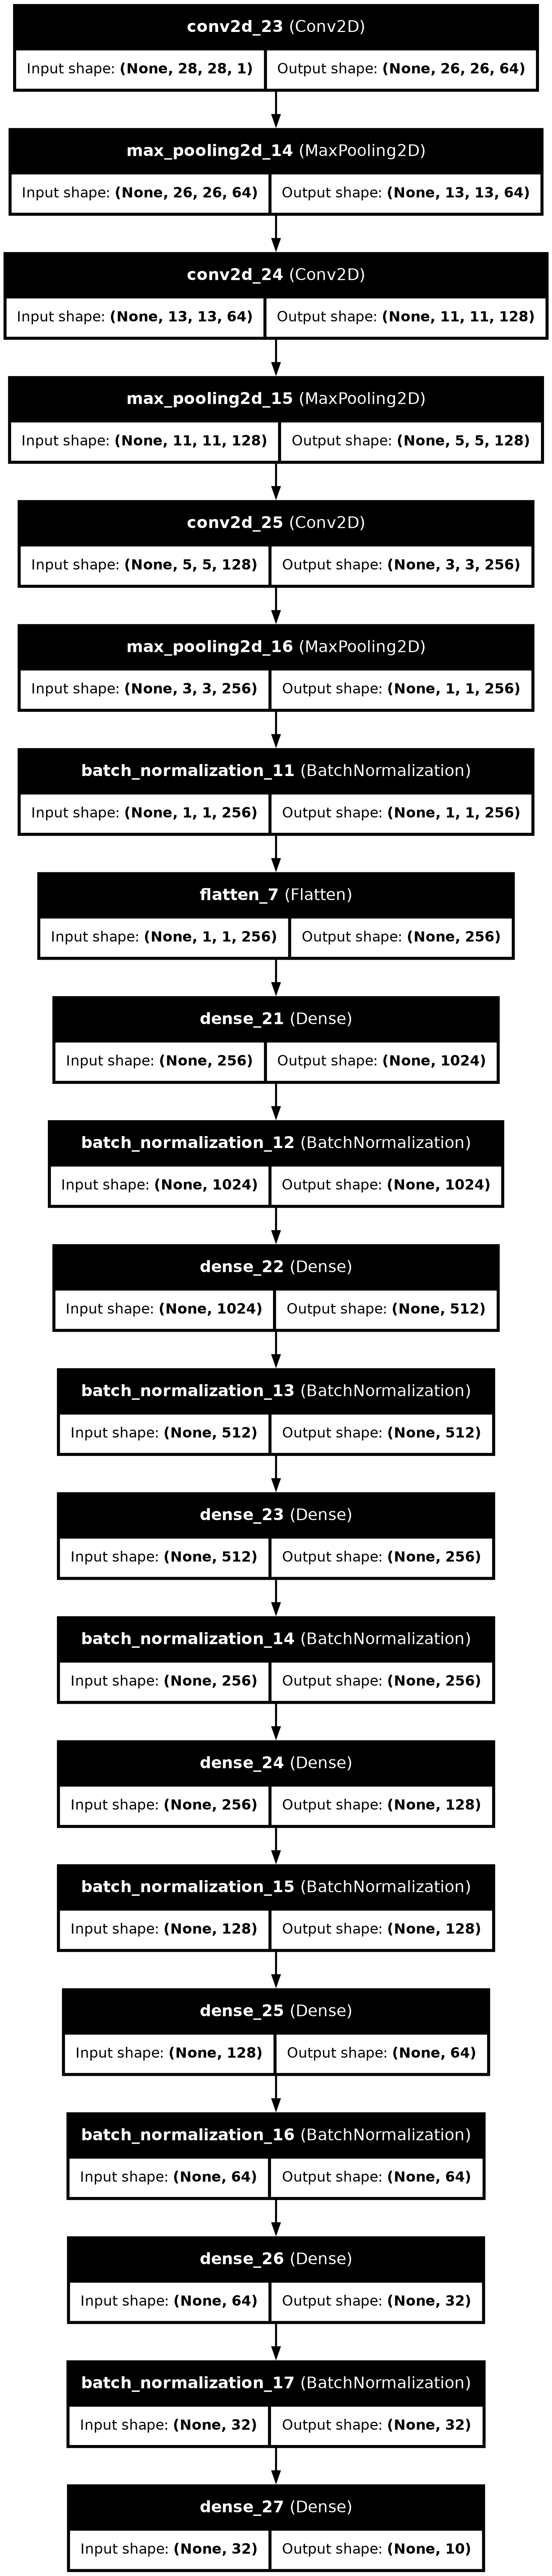

In [104]:
from keras.utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

In [90]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/best_model.keras")

# **4. Evaluate the model**

## 4.1 Evaluate model performance

In [105]:
# Assuming X_test and y_test are your test dataset and labels
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9841 - loss: 0.0490
Test Loss: 0.04482973739504814
Test Accuracy: 0.9861904978752136


## 4.2 Plot the loss and accuracy curves 

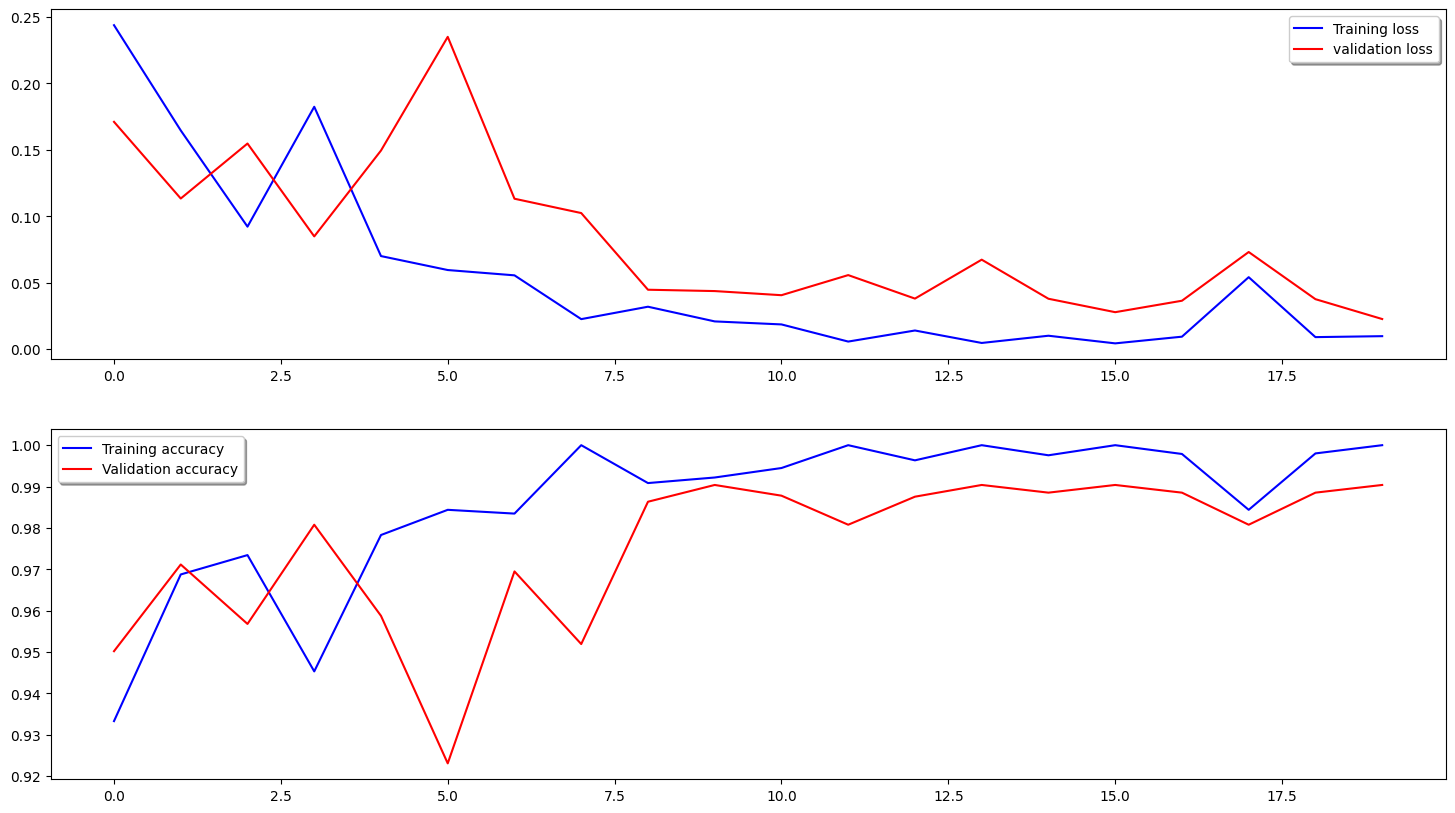

In [106]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.3 Confusion Matrix

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


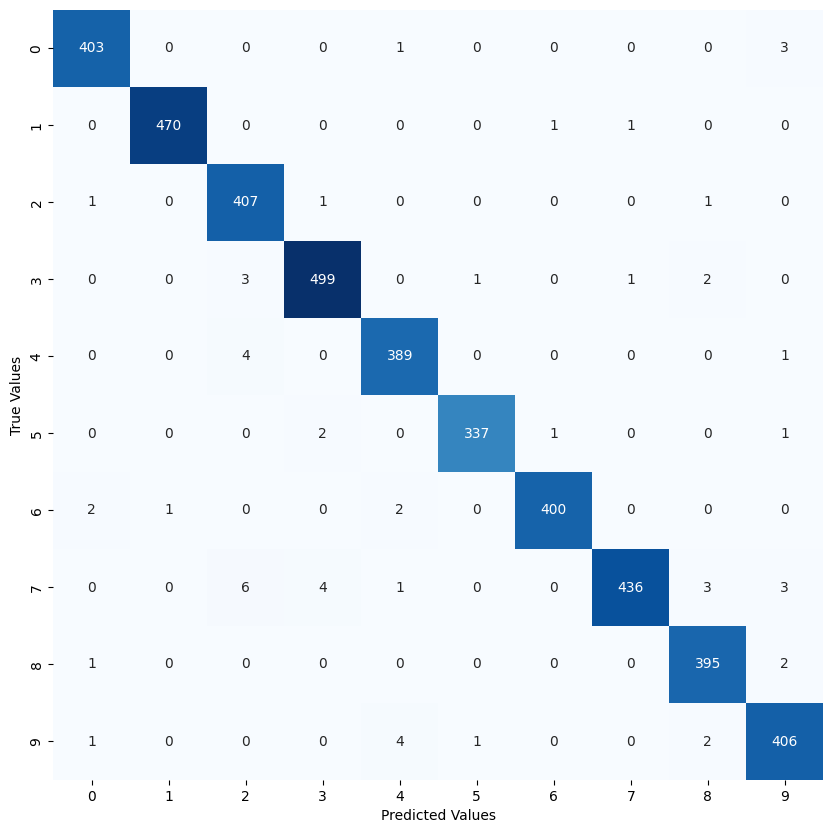

In [107]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

## 4.4 Classification report

In [109]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(10)]
class_names =['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

# Classification report
print(classification_report(Y_test, Y_pred, target_names=class_names, digits=4))

['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
              precision    recall  f1-score   support

        Zero     0.9902    0.9877    0.9890       408
         One     0.9958    0.9979    0.9968       471
         Two     0.9927    0.9690    0.9807       420
       Three     0.9862    0.9862    0.9862       506
        Four     0.9873    0.9798    0.9836       397
        Five     0.9883    0.9941    0.9912       339
         Six     0.9877    0.9950    0.9913       402
       Seven     0.9625    0.9954    0.9787       438
       Eight     0.9925    0.9801    0.9863       403
        Nine     0.9807    0.9760    0.9783       416

    accuracy                         0.9862      4200
   macro avg     0.9864    0.9861    0.9862      4200
weighted avg     0.9863    0.9862    0.9862      4200



## plot the predictions

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


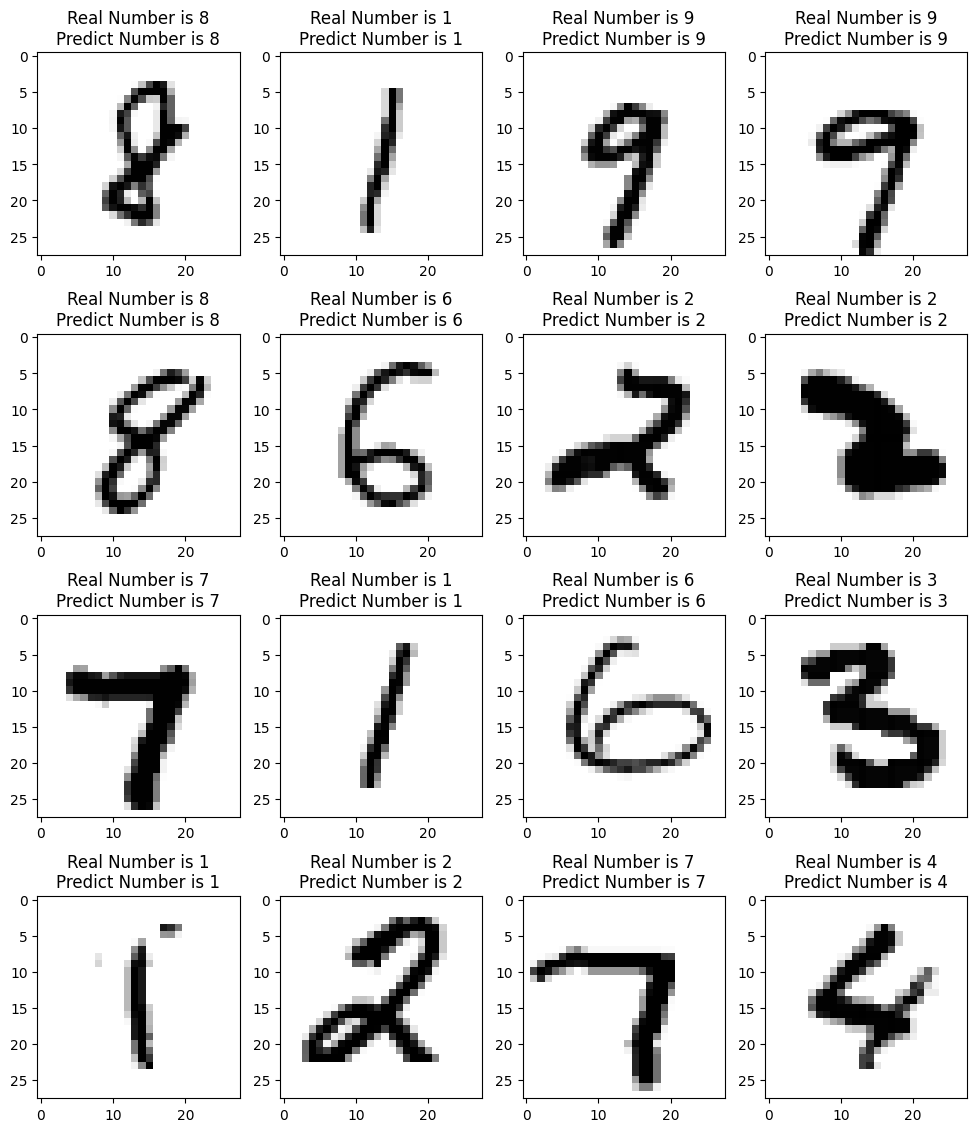

In [92]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

# **5. Submission**

In [105]:
# preprocess test data
test_x = test.values
test_x = test_x / 255.0
test_x = test_x.reshape(-1,28,28,1)

# predict test data
pred = model.predict(test_x, verbose=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [106]:
pred = np.argmax(pred,axis = 1)

In [108]:
# submissions
sub['Label'] = pred
sub.to_csv("CNN_keras_sub_3.csv", index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


# ***Referances***

## 1. Notebook's

In [34]:
# https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook
# https://www.kaggle.com/code/adityaecdrid/mnist-with-keras-for-beginners-99457#Classifcation-Report
# https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1
# https://www.kaggle.com/code/samuelcortinhas/mnist-cnn-data-augmentation-99-6-accuracy
# https://www.tensorflow.org/datasets/keras_example
# https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial

In [ ]:
https://www.kaggle.com/code/elcaiseri/mnist-simple-machine-learning-algorithms?scriptVersionId=90685972